In [ ]:
!trtexec --minShapes=input:1x3x224x224 --maxShapes=input:64x3x224x224 --optShapes=input:32x3x224x224 --onnx="./convnext_tiny.onnx" --workspace=11000 --dumpRefit --dumpProfile --profilingVerbosity=detailed --saveEngine=convnext.engine --dumpLayerInfo --exportLayerInfo=layer.json --exportProfile=profile.json --verbose &> export.log

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd
from trex import *

# Configure a wider output (for the wide graphs)
set_wide_display()

# Choose an engine file to load.  This notebook assumes that you've saved the engine to the following paths.
engine_name = "./convnext.engine"

In [ ]:
assert engine_name is not None
plan = EnginePlan('./layer.json', './profile.json', './profile.metadata.json')

In [ ]:
print(f"Summary for {plan.name}:\n")
plan.summary()

In [ ]:
df = plan.df

In [ ]:
available_cols = df.columns
print(f"These are the column names in the plan\n: {available_cols}")

In [ ]:
plan.df

In [ ]:
formatter = layer_type_formatter if True else precision_formatter
graph = to_dot(plan, formatter)
svg_name = render_dot(graph, engine_name, 'svg')

1.对于GeLu的合并
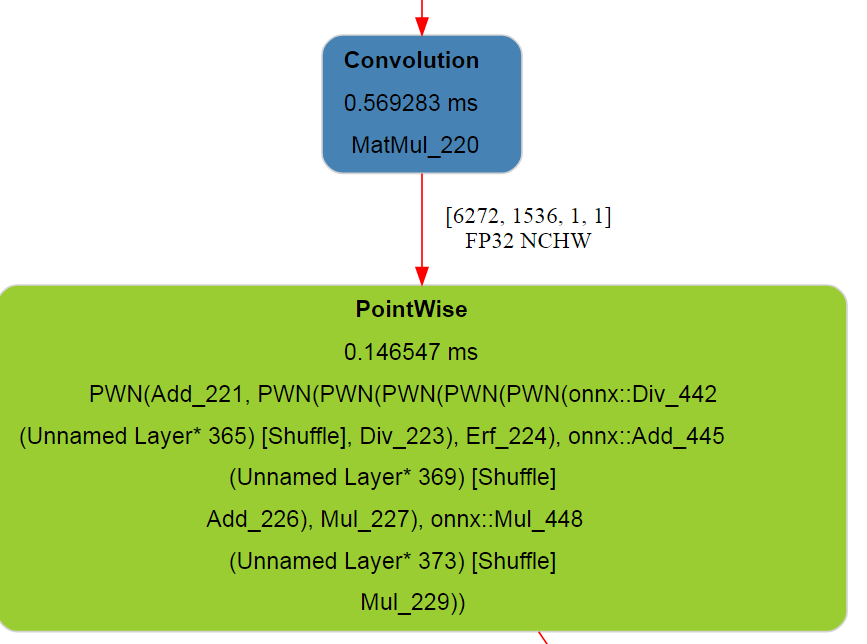

2. 对于channel_last方式LayerNorm的合并
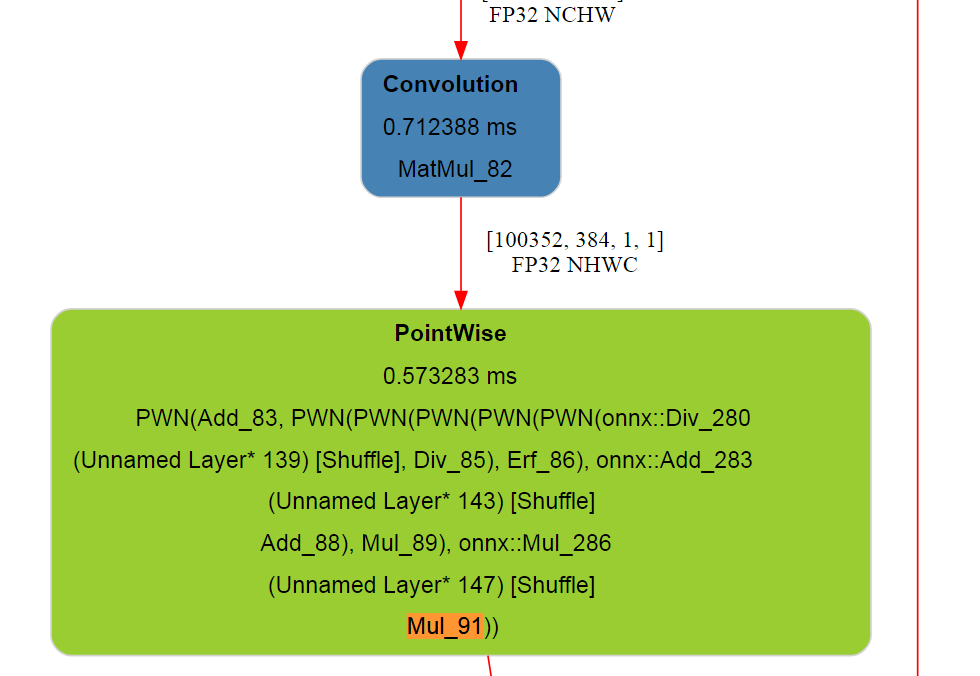

3. channel_first的LayerNorm类型的合并  
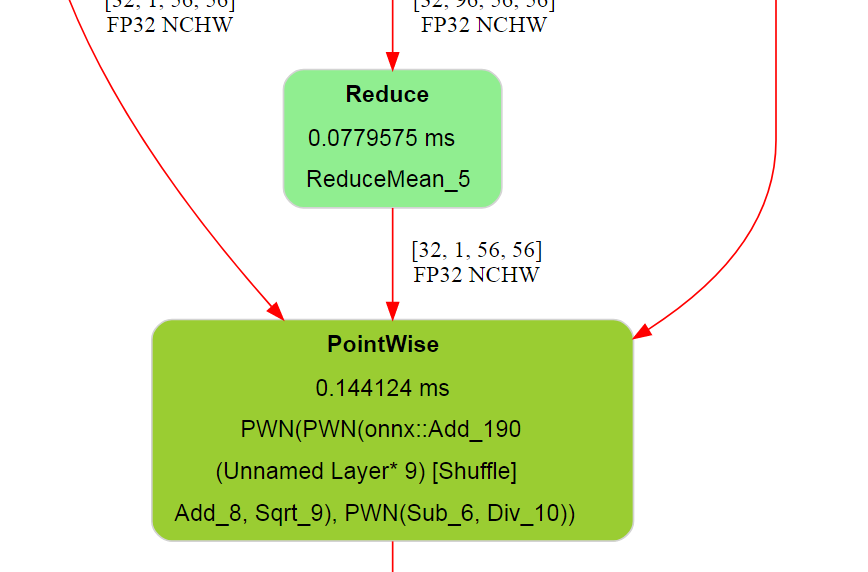

4. gamma的处理  
与Layernorm算子中仿射变换加法操作合并为一个算子  
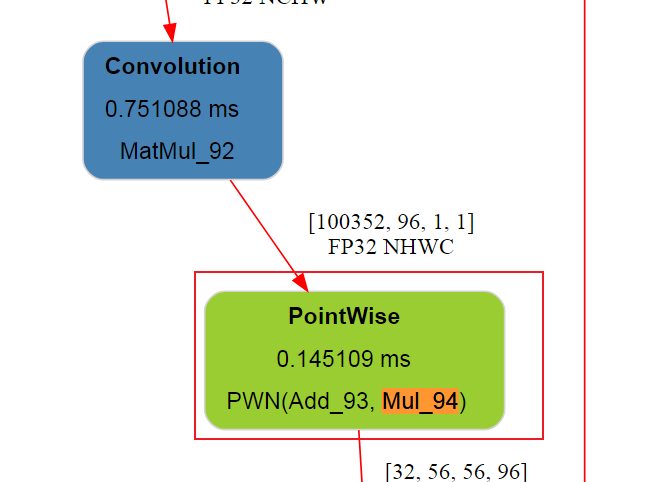

更多资料可以查看  
https://github.com/NVIDIA/TensorRT/blob/main/tools/experimental/trt-engine-explorer/notebooks/tutorial.ipynb  
https://github.com/NVIDIA/TensorRT/tree/main/tools/experimental/trt-engine-explorer

In [ ]:
!nsys profile -o convnext_profile trtexec --loadEngine=convnext.engine --warmUp=0 --duration=0 --iterations=50

# TensorRT的基本使用、对齐torch/trt的输出

In [ ]:
import tensorrt as trt
import numpy as np
import pycuda.driver as cuda
import os

In [ ]:
def GiB(val):
    return val * 1 << 30

In [ ]:
class HostDeviceMem(object):
    def __init__(self, host_mem, device_mem):
        self.host = host_mem
        self.device = device_mem
    
    def free(self):
        self.host = None
        if self.device is not None:
            self.device.free()
            self.device = None
    
    def __del__(self):
        self.free()
    
    def __str__(self):
        return "Host:\n" + str(self.host) + "\nDevice:\n" + str(self.device)

    def __repr__(self):
        return self.__str__()

In [ ]:
# Allocates all buffers required for an engine, i.e. host/device inputs/outputs.
def allocate_buffers(ori_inputs, ori_outputs, engine, context, stream):
    inputs = []
    outputs = []
    bindings = []
    nInput = np.sum([engine.binding_is_input(i) for i in range(engine.num_bindings)])
    
    for i, binding in enumerate(engine):
        size = trt.volume(context.get_binding_shape(i))
        dtype = trt.nptype(engine.get_binding_dtype(binding))
        try:
            if engine.binding_is_input(binding):
                ori_mem = ori_inputs[i]
            else:
                ori_mem = ori_outputs[i - nInput]
        except:
            ori_mem = None
            
        if ori_mem is not None:
            if ori_mem.host.nbytes >= size:
                host_mem = ori_mem.host
                device_mem = ori_mem.device
                # 避免再次释放
                ori_mem.device = None
            else:
                ori_mem.free()
                host_mem = cuda.pagelocked_empty(size, dtype)
                device_mem = cuda.mem_alloc(host_mem.nbytes)
        else:
            # Allocate host and device buffers
            host_mem = cuda.pagelocked_empty(size, dtype)
            device_mem = cuda.mem_alloc(host_mem.nbytes)
        # Append the device buffer to device bindings.
        bindings.append(int(device_mem))
        # Append to the appropriate list.
        if engine.binding_is_input(binding):
            inputs.append(HostDeviceMem(host_mem, device_mem))
        else:
            outputs.append(HostDeviceMem(host_mem, device_mem))
    return inputs, outputs, bindings

In [ ]:
def build_engine(onnx_file_path, enable_fp16 = False, max_batch_size = 64, max_workspace_size = 10, write_engine=True):
    # 通过加载onnx文件，构建engine
    # :param onnx_file_path: onnx文件路径
    # :return: engine
    G_LOGGER = trt.Logger(trt.Logger.WARNING)
    
    explicit_batch = 1 << (int)(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)
    with trt.Builder(G_LOGGER) as builder, builder.create_network(explicit_batch) as network, \
            trt.OnnxParser(network, G_LOGGER) as parser:
        
        config = builder.create_builder_config()
        config.set_memory_pool_limit(trt.MemoryPoolType.WORKSPACE, GiB(max_workspace_size))
        if enable_fp16:
            config.set_flag(trt.BuilderFlag.FP16)
        print('Loading ONNX file from path {}...'.format(onnx_file_path))
        with open(onnx_file_path, 'rb') as model:
            print('Beginning ONNX file parsing')
            parser.parse(model.read())
        print('Completed parsing of ONNX file')
        print('Building an engine from file {}; this may take a while...'.format(onnx_file_path))
        # 重点
        profile = builder.create_optimization_profile()
        profile.set_shape("input", (1, 3, 224, 224), (max_batch_size, 3, 224, 224), (max_batch_size, 3, 224, 224))
        config.add_optimization_profile(profile)

        serialized_engine = builder.build_serialized_network(network, config)
        print("Completed creating Engine")
        # 保存engine文件
        if write_engine:
            
            onnx_path = os.path.realpath(onnx_file_path) 
            engine_file_path = ".".join(onnx_path.split('.')[:-1] + ['trt'])
            with open(engine_file_path, "wb") as f:
                f.write(serialized_engine)
        return serialized_engine

In [ ]:
serialized_engine = build_engine('./convnext_tiny.onnx')

In [ ]:
import pycuda.autoinit

In [ ]:
# This function is generalized for multiple inputs/outputs.
# inputs and outputs are expected to be lists of HostDeviceMem objects.
def do_inference(context, bindings, inputs, outputs, stream):
    # Transfer input data to the GPU.
    [cuda.memcpy_htod_async(inp.device, inp.host, stream) for inp in inputs]
    # Run inference.
    context.execute_async_v2(bindings=bindings, stream_handle=stream.handle)
    # Transfer predictions back from the GPU.
    [cuda.memcpy_dtoh_async(out.host, out.device, stream) for out in outputs]
    # Synchronize the stream
    stream.synchronize()
    # Return only the host outputs.
    return [out.host for out in outputs]

In [ ]:
class TRTClassify(object):
    def __init__(self, engine_path):
        self.engine_path = engine_path
        self.logger = trt.Logger(trt.Logger.VERBOSE)
        self.engine = self._get_engine()
        self.context = self.engine.create_execution_context()
        self.stream = cuda.Stream()
        self.inputs = None
        self.outputs = None


    def _get_engine(self):
        # If a serialized engine exists, use it instead of building an engine.
        f = open(self.engine_path, 'rb')
        runtime = trt.Runtime(self.logger)
        return runtime.deserialize_cuda_engine(f.read())


    def detect(self, image_np_array, cuda_ctx = pycuda.autoinit.context):
        if cuda_ctx:
            cuda_ctx.push()

        batch_size = image_np_array.shape[0]
        # 动态输入
        origin_inputshape = self.context.get_binding_shape(0)
        origin_inputshape[0] = batch_size
        self.context.set_binding_shape(0, (origin_inputshape))
        self.context.set_optimization_profile_async(0, self.stream.handle)
        
        self.inputs, self.outputs, bindings = allocate_buffers(self.inputs, self.outputs, self.engine, self.context, self.stream)
        np_type = trt.nptype(self.engine.get_binding_dtype(0))
        # Do inference
        self.inputs[0].host = np.ascontiguousarray(image_np_array.astype(np_type))
        trt_outputs = do_inference(self.context, bindings=bindings, inputs=self.inputs, outputs=self.outputs,
                                          stream=self.stream)
        
        if cuda_ctx:
            cuda_ctx.pop()
        
        nInput = np.sum([self.engine.binding_is_input(i) for i in range(self.engine.num_bindings)])
        nOutput = self.engine.num_bindings - nInput
        for i in range(nOutput):
            shape = self.context.get_binding_shape(nInput + i)
            trt_outputs[i] = trt_outputs[i].reshape(shape)
        return trt_outputs
    
    def __call__(self, x):
        return self.detect(x)
    
    def __del__(self):
        del self.inputs
        del self.outputs
        del self.stream
        del self.engine
        del self.context

In [ ]:
trt_cls_object = TRTClassify('./convnext_tiny.trt')

In [ ]:
inputs = np.random.rand(64,3,224,224)
outputs_trt = trt_cls_object(inputs)

In [ ]:
outputs_trt[0].shape

In my experience this is usually a problem with pycuda.autoinit that creates a CUDA context separate from the one you are trying to use (elsewhere). I don’t know for sure that this is the issue here, I have not tried your code. See here.

In [ ]:
import torch
import pycuda.autoinit
x = torch.cuda.FloatTensor(8)
from ConvNeXt.models.convnext import convnext_tiny

In [ ]:
model = convnext_tiny(pretrained=False, in_22k=False)

In [ ]:
state_dict = torch.load('./convnext_tiny_1k_224_ema.pth', map_location='cpu')['model']
model.load_state_dict(state_dict)
model = model.eval()

In [ ]:
model = model.cuda()

In [ ]:
with torch.no_grad():
    x = torch.from_numpy(inputs).cuda().float()
    output_torch = model(x)

In [ ]:
del x

In [ ]:
np.allclose(output_torch.detach().cpu().numpy(), outputs_trt, atol=1e-6, rtol=1e-1, equal_nan=True)

In [ ]:
np.abs(output_torch.detach().cpu().numpy() - outputs_trt).max()

In [ ]:
del output_torch

# 查看去除gamme以后的算子合并

In [ ]:
del trt_cls_object

In [ ]:
del model

In [ ]:
torch.cuda.empty_cache()

In [ ]:
serialized_engine = build_engine('./convnext_tiny_fuse_gamma.onnx')

In [ ]:
!trtexec --minShapes=input:1x3x224x224 --maxShapes=input:64x3x224x224 --optShapes=input:32x3x224x224 --onnx="./convnext_tiny_fuse_gamma.onnx" --workspace=11000 --dumpRefit --dumpProfile --profilingVerbosity=detailed --saveEngine=convnext_tiny_fuse_gamma.engine --dumpLayerInfo --exportLayerInfo=layer.json --exportProfile=profile.json --verbose &> export.log

In [ ]:
from trex import EnginePlan, layer_type_formatter, precision_formatter, to_dot, render_dot
plan = EnginePlan('./layer.json', './profile.json', './profile.metadata.json')

In [ ]:
formatter = layer_type_formatter if True else precision_formatter
graph = to_dot(plan, formatter)
engine_name = 'convnext_tiny_fuse_gamma'
svg_name = render_dot(graph, engine_name, 'svg')

1. 去除gamma

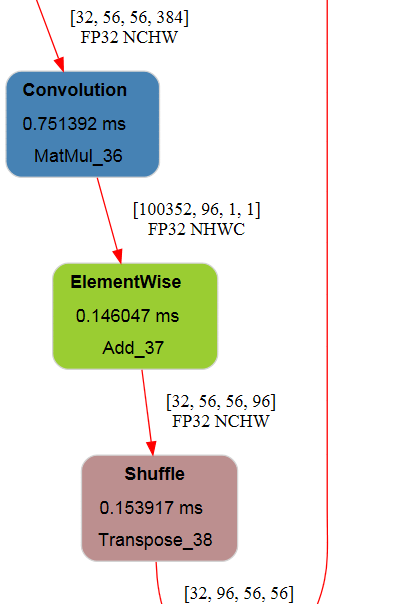

In [ ]:
trt_cls_object = TRTClassify('./convnext_tiny_fuse_gamma.trt')

In [ ]:
inputs = np.random.rand(64,3,224,224)
outputs_trt = trt_cls_object(inputs)

In [ ]:
import torch
import pycuda.driver as cuda
import pycuda.autoinit
x = torch.cuda.FloatTensor(8)
from ConvNeXt.models.convnext import convnext_tiny

In [ ]:
model = convnext_tiny(pretrained=False, in_22k=False)
state_dict = torch.load('./convnext_tiny_1k_224_ema.pth', map_location='cpu')['model']
model.load_state_dict(state_dict)
model = model.eval().cuda()

In [ ]:
with torch.no_grad():
    x = torch.from_numpy(inputs).cuda().float()
    output_torch = model(x)

In [ ]:
del x
np.allclose(output_torch.detach().cpu().numpy(), outputs_trt, atol=1e-6, rtol=1e-1, equal_nan=True)

In [ ]:
np.abs(output_torch.detach().cpu().numpy() - outputs_trt).max()

In [ ]:
import pycuda.driver as cuda
import pycuda.autoinit
trt_cls_object_ori = TRTClassify('./convnext_tiny.trt')

In [ ]:
inputs = np.random.rand(64,3,224,224).astype(np.float32)
# cuda.init()

In [ ]:
for i in range(1000):
    trt_cls_object_ori(inputs)
%timeit trt_cls_object_ori(inputs)

In [ ]:
for i in range(1000):
    trt_cls_object(inputs)
%timeit trt_cls_object(inputs)

In [ ]:
# 回收显存资源
del model
del trt_cls_object
del trt_cls_object_ori

In [ ]:
torch.cuda.empty_cache()

# 输出tensorrt layernorm插件的调研结果
五种算法

In [ ]:
# 看看有多少种channel_first
import onnx_graphsurgeon
import onnx

In [ ]:
onnx_model = onnx.load('./convnext_tiny_rm_gamma_rep_layernorm_gs.onnx')

In [ ]:
for node in onnx_model.graph.node:
    if "LayerNorm" == node.op_type:
        print(node.attribute[0].s.decode('utf-8'))

channels_first的实现成本过高，先不动